## Procedurally Generated Internet Graph

This is an experiment to procedurally generate a graph structure that looks like the real internet.

I have the following goals.
1. A seed value will result in exactly the same structure everytime.
1. A single node and it's connections can be created independently of the entire graph.
  * In other words the generation is independent of the order of the nodes being generated.
  * This will allow a progressive generation from any starting point.

Some notes:
1. There are a lot of floats in the current implementation. It will be hard to
    ensure exact recreation across machines unless a math library (mpmath?)
    is used.
1. A key to the above goals is seeding each time a random number is generated.
Each seed is combined with the node or edge index and a constant scaling factor.

In [12]:
import random
import math
import mpmath
import networkx as nx
import matplotlib.pyplot as plt

num_nodes = 200

seed = 34567122
connectedness_lambda = 1
connectedness_mu = 70
connectedness_sigma = 8
connectedness_w1 = 0.95
connectedness_w2 = 0.05

random.seed(seed)

### Distribution Functions

These are the probability density functions. They return a list of
probabilities that represent a discrete form of the PDFs.

The lists returned should add up to 1.0 (or very close). These lists are meant
to be used used with `random.choices()`.

In [13]:
# Uniform distribution
def uniform_distribution(interval):
    """
    :param interval: Interval of the distribution as a tuple
    :return: Probability mass function as a list
    """
    return [1/(interval[1]-interval[0]) for _ in range(*interval)]

# Normal distribution
def normal_distribution(interval, mu, sigma):
    """
    :param interval: Interval of the distribution as a tuple
    :param mu: mean of distribution
    :param sigma: standard deviation of distribution
    :return: Probability mass function as a list
    """
    return [1/(sigma*math.sqrt(2*math.pi))*math.exp(-0.5*(math.pow((x-mu)/sigma,2)))
            for x in range(*interval)]

# Poisson distribution
def poisson_distribution(interval, _lambda=1):
    """
    :param interval: Interval of the distribution as a tuple
    :param _lambda: expected value of x
    :return: Probability mass function as a list
    """
    return [(pow(_lambda,x)*math.exp(-_lambda))/mpmath.fac(x)
            for x in range(*interval)]

# Combine distributions
def combine(dist1, dist2, dist1_weight=0.5, dist2_weight=0.5):
    if len(dist1) != len(dist2):
        raise ValueError("Length of lists must be the same dist1[{}] != dist2[{}]")\
            .format(len(dist1), len(dist2))
    if (dist1_weight+dist2_weight) != 1.0:
        raise ValueError("Weights must sum to 1.0")

    dist_sum = []
    for a, b in zip(dist1, dist2):
        dist_sum.append((a*dist1_weight) + (b*dist2_weight))
    return dist_sum

### Create network nodes

Create a list of all nodes on the internet. This is simple.

Possible enhancements:
* Make the IP address network make sense with the overall graph.

In [14]:
def rand_ip(node_index):
    random.seed(seed + (node_index * 29401))
    return "{}.{}.{}.{}".format(
        random.randrange(255),
        random.randrange(255),
        random.randrange(255),
        random.randrange(255),
    )

node_indices = list(range(num_nodes))
nodes = [(i, {
    "ip": rand_ip(i),
    'connectedness': None,
}) for i in node_indices]

### Create network connections

Create the edges

In [15]:
def rand_edges(node_index, interval, pdf):
    random.seed(seed + (node_index * 108799))
    num_edges = random.choices(range(*interval), weights=pdf, k=1)[0]
    connections = random.sample(node_indices, num_edges)
    return [(node_index, c) for c in connections]

interval = (1, len(node_indices))
d1 = poisson_distribution(interval, connectedness_lambda)
d2 = normal_distribution(interval, connectedness_mu, connectedness_sigma)
d_comb = combine(d1, d2, dist1_weight=connectedness_w1,
                 dist2_weight=connectedness_w2)
edges = []
for i in node_indices:
    edges += rand_edges(i, interval, d_comb)

Show the internet!!!

<ipython-input-16-a0b2ea55c64f>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


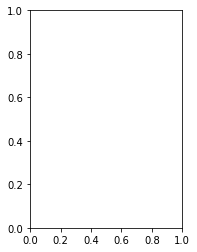

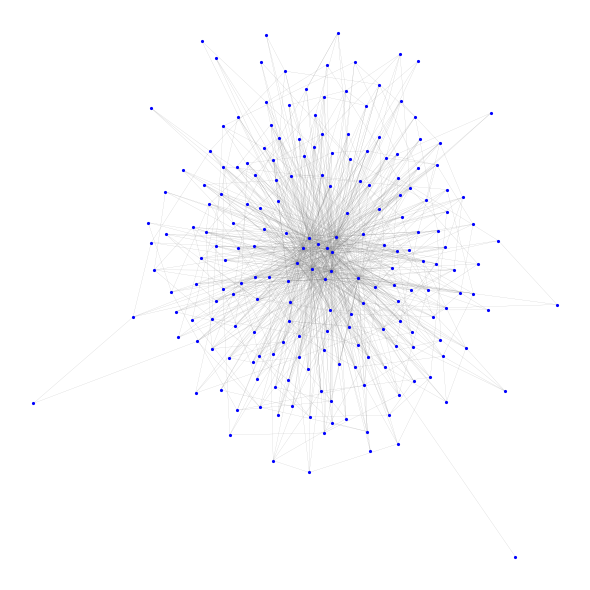

In [16]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

plt.subplot(121)
# nx.draw(G, with_labels=True, font_weight='bold')

options = {
    'node_color': 'blue',
    "edge_color": "grey",
    'node_size': 10,
    "linewidths": 0,
    'width': 0.1,
    'with_labels': False,
}
pos = nx.spring_layout(G)

fig = plt.figure(figsize=(8,8))
nx.draw(G, pos=pos, **options)
fig.show()

Test generating nodes and connections arbitrarily

In [44]:
from pyvis.network import Network
gviz = Network(height=800, width=800, notebook=True)
gviz.toggle_hide_edges_on_drag(True)
gviz.barnes_hut(
    gravity=-10,
    central_gravity=0.05,
    spring_length=500,
    spring_strength=0.001,
    damping=0.09,
    overlap=0.5
)
gviz.from_nx(G)
gviz.show('network-graph.html')